In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree

In [60]:
df = pd.read_csv('/Users/baptistecarbillet/Documents/MachineLearning1/smoking_driking_dataset_Ver01.csv')

Data are a bit unbalanced. Lot of values. Im only gonna select a subsample of the data, mainly to have faster training time.

In [61]:
df.drop('DRK_YN', axis=1, inplace=True)

In [62]:
#Male get one hot encoding
df['sex'] = df['sex'].apply(lambda x: 1 if x == 'Male' else 0)

In [63]:
#normalization
#df.iloc[:,:-1]=  (df.iloc[:,:-1] - df.iloc[:,:-1].mean()) / (df.iloc[:,:-1].std())

We split the data, for each class, we get 25000 samples. 20 000 will be used for training, 5000 for testing.

In [64]:
random_state = 75
df_1 = df[df['SMK_stat_type_cd'] == 1.0].sample(5000,random_state=random_state)
df_2 = df[df['SMK_stat_type_cd'] == 2.0].sample(5000,random_state=random_state)
df_3 = df[df['SMK_stat_type_cd'] == 3.0].sample(5000,random_state=random_state)

In [65]:
X_1,y_1 = np.array(df_1.drop('SMK_stat_type_cd',axis=1)),np.array(df_1['SMK_stat_type_cd'])
X_2,y_2 = np.array(df_2.drop('SMK_stat_type_cd',axis=1)),np.array(df_2['SMK_stat_type_cd'])
X_3,y_3 = np.array(df_3.drop('SMK_stat_type_cd',axis=1)),np.array(df_3['SMK_stat_type_cd'])

In [66]:
from sklearn.model_selection import train_test_split

random_state = 75 #Paris

X_train_1,X_test_1,y_train_1,y_test_1 = train_test_split(X_1,y_1,test_size=0.2,random_state=random_state)
X_train_2,X_test_2,y_train_2,y_test_2 = train_test_split(X_2,y_2,test_size=0.2,random_state=random_state)
X_train_3,X_test_3,y_train_3,y_test_3 = train_test_split(X_3,y_3,test_size=0.2,random_state=random_state)

In [67]:
X_train = np.concatenate((X_train_1,X_train_2,X_train_3))
y_train = np.concatenate((y_train_1,y_train_2,y_train_3))

X_test = np.concatenate((X_test_1,X_test_2,X_test_3))
y_test = np.concatenate((y_test_1,y_test_2,y_test_3))

In [68]:
#We shuffle the data
from sklearn.utils import shuffle
X_train,y_train = shuffle(X_train,y_train,random_state=random_state)
X_test,y_test = shuffle(X_test,y_test,random_state=random_state)

In [70]:
from sklearn.model_selection import KFold, cross_validate
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True,random_state=random_state)

model = tree.DecisionTreeClassifier(random_state=random_state)
scoring=('accuracy')

cv_results = cross_validate(model, X_train, y_train, cv=kf, scoring=scoring, return_train_score=True,return_estimator=True)

for i in range(n_splits):
    print('Fold',i+1)
    print('Train accuracy:',cv_results['train_score'][i])
    print('Test accuracy:',cv_results['test_score'][i])
    print('Depth:',cv_results['estimator'][i].get_depth())
    print('')





Fold 1
Train accuracy: 1.0
Test accuracy: 0.5083333333333333
Depth: 34

Fold 2
Train accuracy: 1.0
Test accuracy: 0.5133333333333333
Depth: 31

Fold 3
Train accuracy: 1.0
Test accuracy: 0.51625
Depth: 30

Fold 4
Train accuracy: 1.0
Test accuracy: 0.51875
Depth: 36

Fold 5
Train accuracy: 1.0
Test accuracy: 0.53375
Depth: 33



Pre prunning

In [71]:
max_depth = [d for d in range(1,34)]
train_accuracy_pre = []
test_accuracy_pre = []
fit_time = []


for d in max_depth:
    
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=True,random_state=random_state)

    model = tree.DecisionTreeClassifier(max_depth=d,random_state=random_state)
    scoring=('accuracy')

    cv_results = cross_validate(model, X_train, y_train, cv=kf, scoring=scoring, return_train_score=True,return_estimator=True)
    train_accuracy_pre.append(np.mean(cv_results['train_score']))
    test_accuracy_pre.append(np.mean(cv_results['test_score']))
    
    fit_time.append(np.mean(cv_results['fit_time']))

    
    

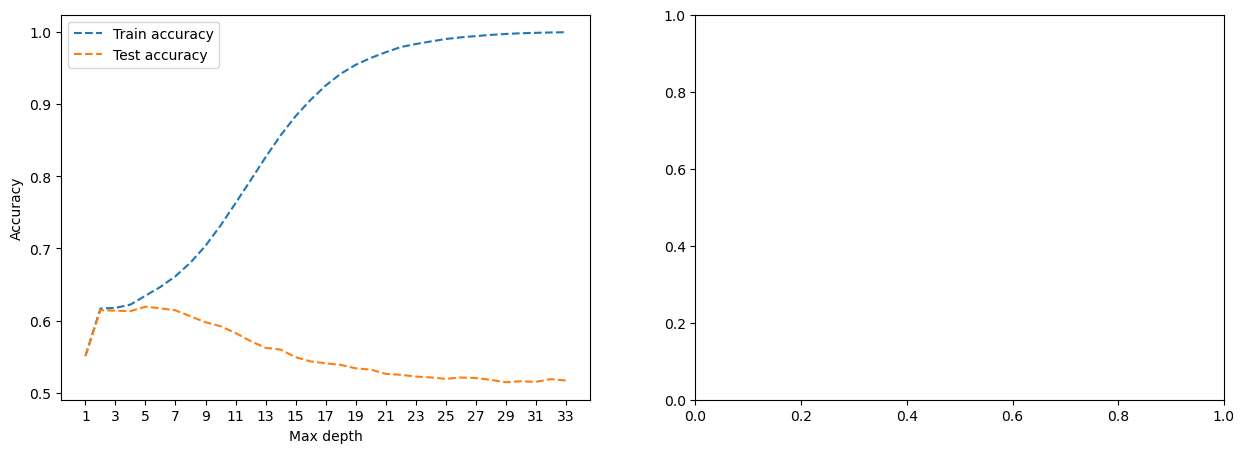

In [72]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(max_depth,train_accuracy_pre,label='Train accuracy',linestyle='--')
##With dashed line
ax[0].plot(max_depth,test_accuracy_pre,label='Test accuracy',linestyle='--')
ax[0].set_xlabel('Max depth')
ax[0].set_ylabel('Accuracy')
ax[0].set_xticks(max_depth[::2])
ax[0].legend()

ax[1].plot(max_depth,fit_time,label='Fit time',linestyle='--')

plt.show()

In [73]:
print('Best max_depth:',max_depth[np.argmax(test_accuracy_pre)])
print('Best test accuracy:',np.max(test_accuracy_pre))

Best max_depth: 5
Best test accuracy: 0.6193333333333333


We can see that the model starts to overfit after depth of 5. High variance. We will use pre prunning to reduce the variance.

# plot tree of depth 2

In [74]:
#plot model tree with graphviz
model_plot = tree.DecisionTreeClassifier(max_depth=2,random_state=random_state)
model_plot.fit(X_train,y_train)
import graphviz
dot_data = tree.export_graphviz(model_plot, out_file=None, 
                      feature_names=df.drop('SMK_stat_type_cd',axis=1).columns.to_list(),  
                      class_names=['non Smoker','Former Smoker','Smoker'],  
                      filled=True, rounded=True,  
                      special_characters=True)
graph = graphviz.Source(dot_data)
graph.render('tree',view=True)

'tree.pdf'

## Confusion matrix:

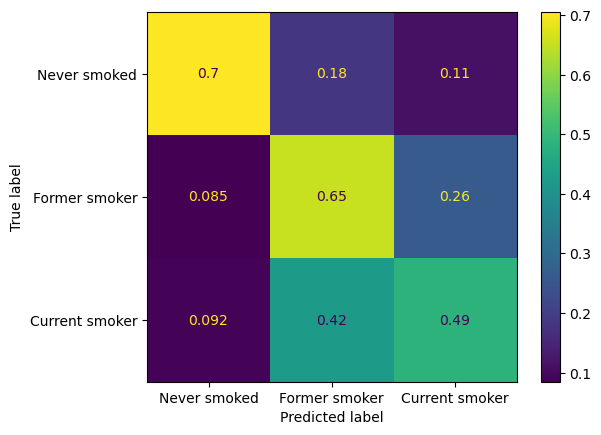

In [75]:
X_train_cm,X_val_cm,y_train_cm,y_val_cm = train_test_split(X_train,y_train,test_size=0.2,random_state=random_state)
model = tree.DecisionTreeClassifier(max_depth=5)
model.fit(X_train_cm,y_train_cm)

y_pred_val_cm = model.predict(X_val_cm)
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val_cm,y_pred_val_cm,normalize='true')
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                           display_labels= ['Never smoked','Former smoker','Current smoker'])
disp.plot()


Post pruning :

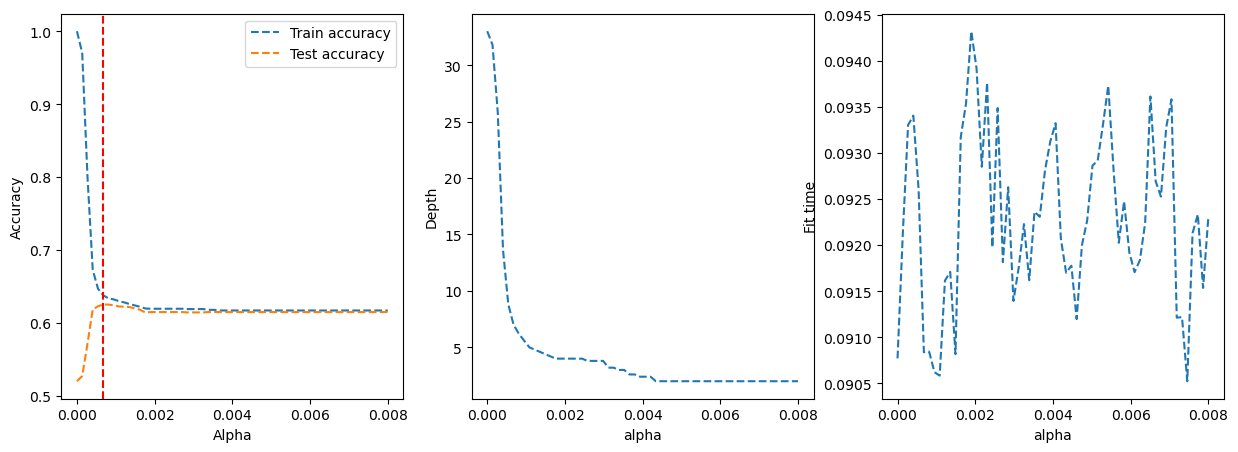

In [84]:
import time
train_accuracy_post = []
test_accuracy_post = []
depth = []
fit_time = []
from sklearn.metrics import  accuracy_score
alpha_list = np.linspace(0,0.008,60)

for _,alpha in enumerate(alpha_list):
    
    
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=True,random_state=random_state)

    model = tree.DecisionTreeClassifier(ccp_alpha=alpha)
    scoring=('accuracy')

    cv_results = cross_validate(model, X_train, y_train, cv=kf, scoring=scoring, return_train_score=True,return_estimator=True)
    train_accuracy_post.append(np.mean(cv_results['train_score']))
    test_accuracy_post.append(np.mean(cv_results['test_score']))
    depth.append(np.mean([estimator.get_depth() for estimator in cv_results['estimator']]))
    fit_time.append(np.mean(cv_results['fit_time']))
    
    
fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].plot(alpha_list,train_accuracy_post,label='Train accuracy',linestyle='--')
##With dashed line
ax[0].plot(alpha_list,test_accuracy_post,label='Test accuracy',linestyle='--')
ax[0].set_xlabel('Alpha')
ax[0].set_ylabel('Accuracy')
#plot vertical line at best alpha
ax[0].axvline(alpha_list[np.argmax(test_accuracy_post)],color='red',linestyle='--')

ax[0].legend()

ax[1].plot(alpha_list,depth,label='depth',linestyle='--')
ax[1].set_xlabel('alpha')
ax[1].set_ylabel('Depth')

ax[2].plot(alpha_list,fit_time,label='fit_time',linestyle='--')
ax[2].set_xlabel('alpha')
ax[2].set_ylabel('Fit time')

plt.show()

/var/folders/_x/_fqb6r5s5rd6tk1hhyl_y7qh0000gn/T/ipykernel_65673/2998954.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(alpha_list,rotation=90)
/var/folders/_x/_fqb6r5s5rd6tk1hhyl_y7qh0000gn/T/ipykernel_65673/2998954.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.round(alpha_list,5))


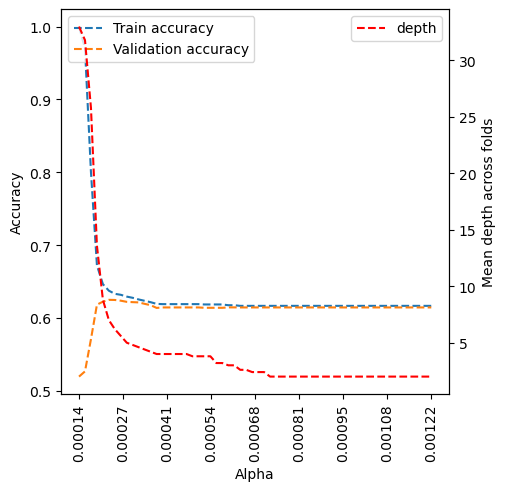

In [85]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(alpha_list,train_accuracy_post,label='Train accuracy',linestyle='--')
##With dashed line
ax.plot(alpha_list,test_accuracy_post,label='Validation accuracy',linestyle='--')
ax.set_xlabel('Alpha')
ax.set_ylabel('Accuracy')
#rotate x ticks
ax.set_xticklabels(alpha_list,rotation=90)
#round x ticks
ax.set_xticklabels(np.round(alpha_list,5))
#plot vertical line at best alpha
#ax.axvline(alpha_list[np.argmax(test_accuracy_post)],color='red',linestyle='--')

ax.legend(loc = 'upper left')

#set second axis on the right for max depth and add mean depth to the plot
ax2 = ax.twinx()
ax2.plot(alpha_list,depth,label='depth',linestyle='--',color='red')
ax2.set_ylabel('Mean depth across folds')
ax2.legend(loc='upper right')



plt.show()

In [87]:
print('Best alpha:',alpha_list[np.argmax(test_accuracy_post)])
print('Best accuracy:',np.max(test_accuracy_post))
print('Best depth:',depth[np.argmax(test_accuracy_post)])

Best alpha: 0.0006779661016949152
Best accuracy: 0.625
Best depth: 7.0


## Grid search

In [44]:
from sklearn.model_selection import GridSearchCV
decisionT_param = {'max_depth':[d for d in range(1,12)],
                   'splitter':['best','random'],
                     'criterion':['gini','entropy'],
                     'min_samples_split':[1,0.01,0.05,0.1,0.2,0.3,0.4,0.5],
                }

grid = GridSearchCV(tree.DecisionTreeClassifier(random_state=random_state),decisionT_param,scoring='accuracy',cv=5)

grid.fit(X_train,y_train)

/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
220 fits failed out of a total of 1760.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
220 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 637, in _validate_params

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=75),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
                         'min_samples_split': [1, 0.01, 0.05, 0.1, 0.2, 0.3,
                                               0.4, 0.5],
                         'splitter': ['best', 'random']},
             scoring='accuracy')

In [45]:
grid.best_params_

{'criterion': 'entropy',
 'max_depth': 9,
 'min_samples_split': 0.05,
 'splitter': 'best'}

In [46]:
grid.best_score_

0.6272500000000001

### Learning curve :

In [47]:
X_train_lc,X_val_lc,y_train_lc,y_val_lc = train_test_split(X_train,y_train,test_size=0.2,random_state=random_state)

model = tree.DecisionTreeClassifier(max_depth=9, criterion='entropy', min_samples_split=0.05, splitter='best',random_state=random_state)
model.fit(X_train_lc,y_train_lc)


DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_split=0.05,
                       random_state=75)

In [48]:
#Select a sample of X_train, with the corresponding y_train
train_acc_lc = []
val_acc_lc = []


for sample in np.linspace(0.01,0.99,98):
    X_train_sample,X_out_sample,y_train_sample,y_out_sample = train_test_split(X_train_lc,y_train_lc,test_size=float(1 - sample),random_state=random_state)
    
    model = tree.DecisionTreeClassifier(max_depth=9, criterion='entropy', min_samples_split=0.05, splitter='best',random_state=random_state)
    model.fit(X_train_sample,y_train_sample)
    
    y_pred = model.predict(X_val_lc)
    #Train accuracy
    y_pred_train = model.predict(X_train_sample)
    train_acc_lc.append(accuracy_score(y_train_sample,y_pred_train))
    
    #Validation accuracy
    val_acc_lc.append(accuracy_score(y_val_lc,y_pred))
    
    

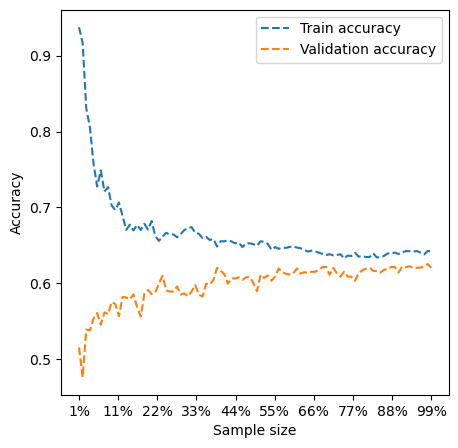

In [49]:
fig, ax = plt.subplots(figsize=(5,5))

ax.plot(np.linspace(0.01,0.99,98),train_acc_lc,label='Train accuracy',linestyle='--')
##With dashed line

ax.plot(np.linspace(0.01,0.99,98),val_acc_lc,label='Validation accuracy',linestyle='--')

ax.set_xlabel('Sample size')
ax.set_ylabel('Accuracy')
#x_tick as percentage
ax.set_xticks(np.linspace(0.01,0.99,10))
ax.set_xticklabels([str(int(i*100))+'%' for i in np.linspace(0.01,0.99,10)])
ax.legend()

plt.show()

## Confusion matrix for best model

Train accuracy: 0.6423958333333334
Validation accuracy: 0.62


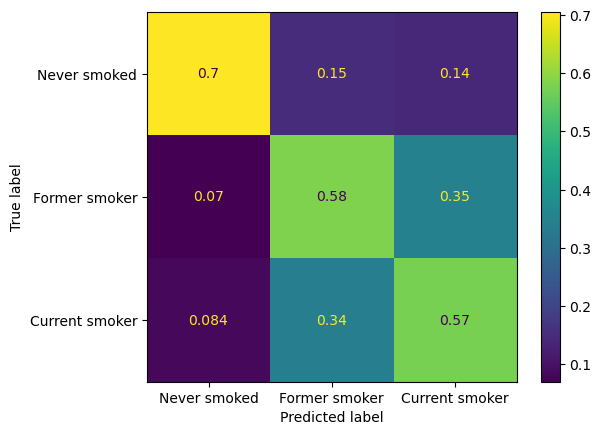

In [83]:

model = tree.DecisionTreeClassifier(max_depth=9, criterion='entropy', min_samples_split=0.05, splitter='best',random_state=random_state)
model.fit(X_train_lc,y_train_lc)

y_pred_val = model.predict(X_val_lc)
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val_lc,y_pred_val,normalize='true')
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                           display_labels= ['Never smoked','Former smoker','Current smoker'])
disp.plot()

#print accuracy

print('Train accuracy:',accuracy_score(y_train_lc,model.predict(X_train_lc)))
print('Validation accuracy:',accuracy_score(y_val_lc,y_pred_val))


## Confusion Matrix by sex : for validation

In [78]:
X_val_lc_male = X_val_lc[X_val_lc[:,0] > 0.5]
y_val_lc_male = y_val_lc[X_val_lc[:,0] > 0.5]

X_val_lc_female = X_val_lc[X_val_lc[:,0] < 0.5]
y_val_lc_female = y_val_lc[X_val_lc[:,0] < 0.5]

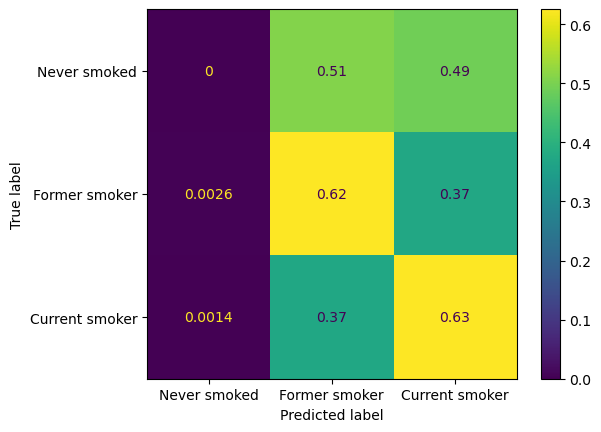

In [79]:
##Split confusion matrix by gender
#Male

y_pred_male = model.predict(X_val_lc_male)

cm = confusion_matrix(y_val_lc_male,y_pred_male,normalize='true')
#plot confusion matrix

from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                           display_labels= ['Never smoked','Former smoker','Current smoker'],)
disp.plot()

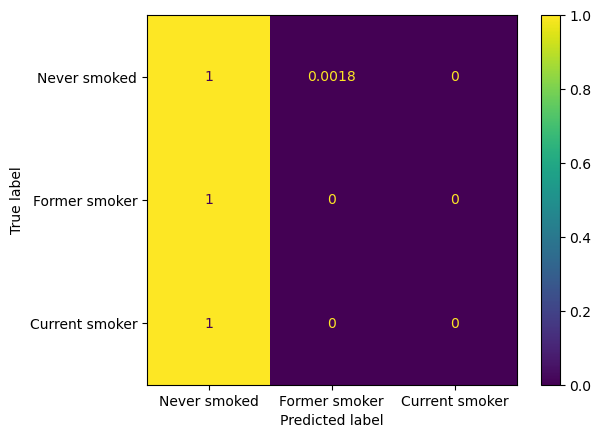

In [80]:
##Split confusion matrix by gender
#female
y_pred_female = model.predict(X_val_lc_female)

cm = confusion_matrix(y_val_lc_female,y_pred_female,normalize='true')
#plot confusion matrix

from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                           display_labels= ['Never smoked','Former smoker','Current smoker'],)
disp.plot()

0.585


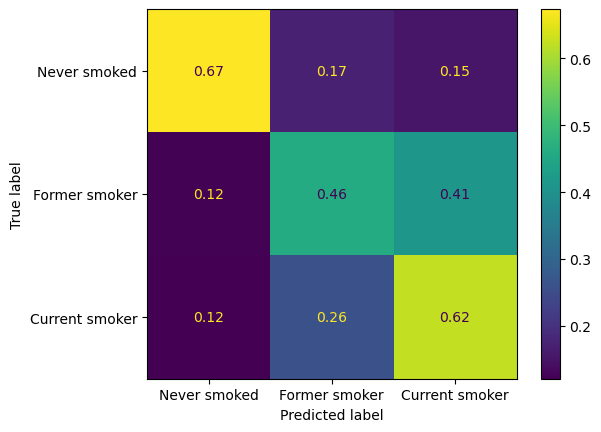

In [82]:
#Fit model without the sex

SexlessModel = tree.DecisionTreeClassifier(max_depth=9, criterion='entropy', min_samples_split=0.05, splitter='best',random_state=random_state)
SexlessModel.fit(X_train_lc[:,1:],y_train_lc)

y_pred_sexless = SexlessModel.predict(X_val_lc[:,1:])
cm = confusion_matrix(y_val_lc,y_pred_sexless,normalize='true')
#plot confusion matrix

from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                           display_labels= ['Never smoked','Former smoker','Current smoker'],)
disp.plot()

#print accuracy

print(accuracy_score(y_val_lc,y_pred_sexless))

## Data Augmentation ? Will increasing the number of odd examples help ? (By odd I mean women who smoke or women who dont smoke)

In [99]:
#Percentage of Men
X_train_lc[X_train_lc[:,0] > 0.5].shape[0] / X_train_lc.shape[0]

0.7092708333333333

70 % of men in the validation dataset

In [97]:
# % of Men who dont smole
X_train_lc[np.logical_and(X_train_lc[:,0] > 0.5, (y_train_lc == 1))].shape[0]/X_train_lc.shape[0]

0.09208333333333334

In [98]:
#% of women who smokes
X_train_lc[np.logical_and(X_train_lc[:,0] < 0.5, (y_train_lc > 1))].shape[0]/X_train_lc.shape[0]

0.049479166666666664

We ll artificially duplicate the training exemple to see if it increases the accuracy of the model.

In [112]:
X_train_men_no_smoke = X_train_lc[np.logical_and(X_train_lc[:,0] > 0.5, (y_train_lc == 1))]
X_train_woman_smoke = X_train_lc[np.logical_and(X_train_lc[:,0] < 0.5, (y_train_lc > 1))]

y_train_men_no_smoke = y_train_lc[np.logical_and(X_train_lc[:,0] > 0.5, (y_train_lc == 1))]
y_train_woman_smoke = y_train_lc[np.logical_and(X_train_lc[:,0] < 0.5, (y_train_lc > 1))]

#Create an array that is the concatenation of X_train and three copy of those two arrays
for i in range(1,5):
    X_male_ns = np.concatenate((X_train_men_no_smoke,) * i, axis=0)
    X_woman_s = np.concatenate((X_train_woman_smoke,) * i, axis=0)
    
    y_male_ns = np.concatenate((y_train_men_no_smoke,) * i, axis=0)
    y_woman_s = np.concatenate((y_train_woman_smoke,) * i, axis=0)
    
    new_X_train = np.concatenate((X_train_lc,X_male_ns,X_woman_s),axis=0)
    new_y_train = np.concatenate((y_train_lc,y_male_ns,y_woman_s), axis=0)

    model = tree.DecisionTreeClassifier(max_depth=9, criterion='entropy', min_samples_split=0.05, splitter='best',random_state=random_state)
    model.fit(new_X_train,new_y_train)
    #print accuracy
    print("Number of times we repeat the minority class:",i)
    print("accuracy {}".format(accuracy_score(model.predict(X_val_lc),y_val_lc)))

Number of times we repeat the minority class: 1
accuracy 0.5970833333333333
Number of times we repeat the minority class: 2
accuracy 0.5433333333333333
Number of times we repeat the minority class: 3
accuracy 0.5233333333333333
Number of times we repeat the minority class: 4
accuracy 0.42041666666666666


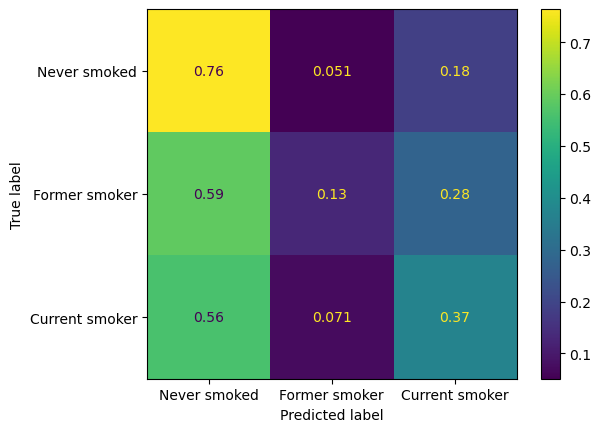

In [113]:
# Confusion matrix:
y_pred = model.predict(X_val_lc)
cm = confusion_matrix(y_val_lc,y_pred,normalize='true')
#plot confusion matrix

from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels= ['Never smoked','Former smoker','Current smoker'],)
disp.plot()

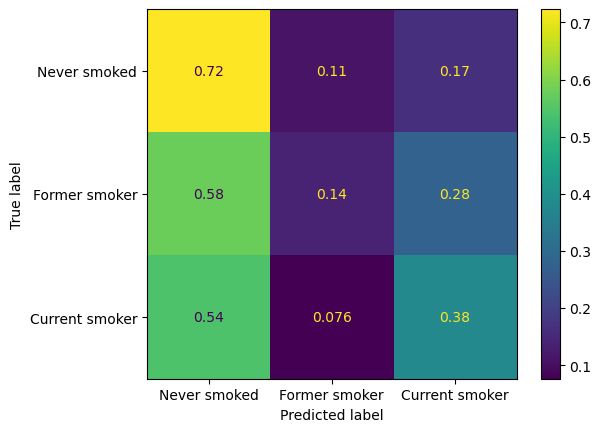

In [114]:
##Split confusion matrix by gender
#Male

y_pred_male = model.predict(X_val_lc_male)

cm = confusion_matrix(y_val_lc_male,y_pred_male,normalize='true')
#plot confusion matrix

from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                           display_labels= ['Never smoked','Former smoker','Current smoker'],)
disp.plot()

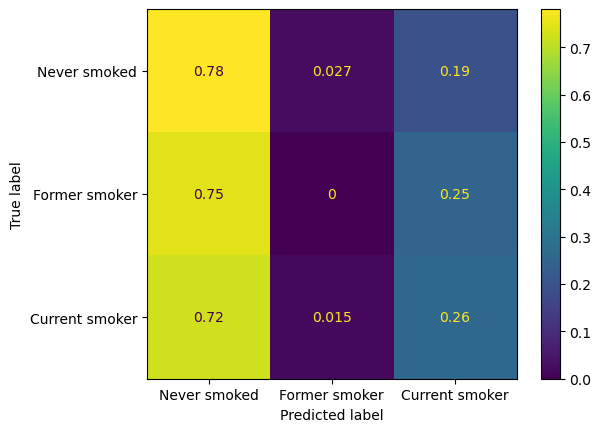

In [115]:
##Split confusion matrix by gender
#female
y_pred_female = model.predict(X_val_lc_female)

cm = confusion_matrix(y_val_lc_female,y_pred_female,normalize='true')
#plot confusion matrix

from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                           display_labels= ['Never smoked','Former smoker','Current smoker'],)
disp.plot()

## Model Overfitted

In [72]:
modelOverfitted = tree.DecisionTreeClassifier(random_state=random_state)
modelOverfitted.fit(X_train_lc,y_train_lc)
modelOverfitted.get_depth()

34

In [73]:
node_indicator = modelOverfitted.decision_path(X_val_lc)

n_nodes = modelOverfitted.tree_.node_count
children_left = modelOverfitted.tree_.children_left
children_right = modelOverfitted.tree_.children_right
feature = modelOverfitted.tree_.feature
threshold = modelOverfitted.tree_.threshold
values = modelOverfitted.tree_.value

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

#last_depth contains the last depth of each sample
last_depth = np.zeros(X_val_lc.shape[0])

for i in range(X_val_lc.shape[0]):
    ind = node_indicator[i].indices.tolist()
    
    for x in ind:
        if is_leaves[x]:
            last_depth[i] = node_depth[x]
            break
    

In [74]:
#This is the quantile of the depth of classification on the validation set
np.quantile(np.array(last_depth),(np.linspace(0,1,11)))

array([ 4., 10., 12., 13., 14., 15., 17., 18., 20., 24., 34.])

# Score on test

In [90]:
bestModel = tree.DecisionTreeClassifier(max_depth=9, criterion='entropy', min_samples_split=0.05, splitter='best',random_state=random_state)
bestModel.fit(X_train,y_train)
accuracy_score(y_test,bestModel.predict(X_test))

0.63

In [ ]:
# COnfusion matrix

In [88]:
#
X_test_male = X_test[X_test[:,0] > 0.5]
y_test_male = y_test[X_test[:,0] > 0.5]

X_test_female = X_test[X_test[:,0] < 0.5]
y_test_female = y_test[X_test[:,0] < 0.5]

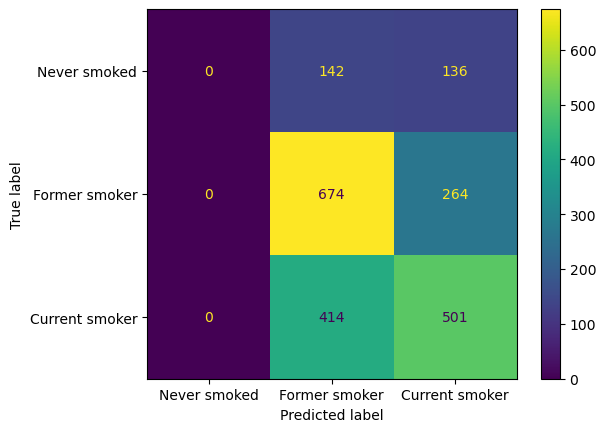

In [91]:
y_pred_male = bestModel.predict(X_test_male)

cm = confusion_matrix(y_test_male,y_pred_male)
#plot confusion matrix

from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                           display_labels= ['Never smoked','Former smoker','Current smoker'],)
disp.plot()

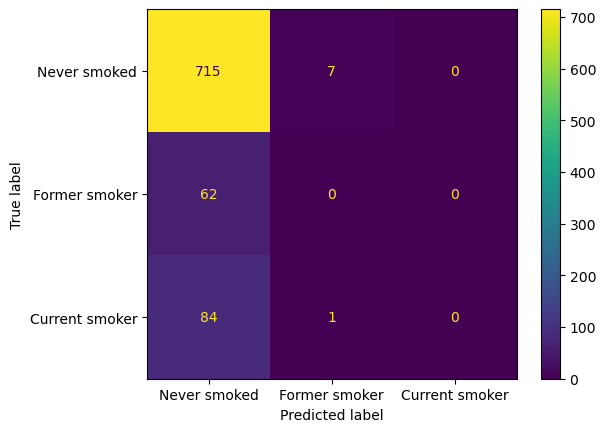

In [92]:
y_pred_female = bestModel.predict(X_test_female)

cm = confusion_matrix(y_test_female,y_pred_female)
#plot confusion matrix

from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                           display_labels= ['Never smoked','Former smoker','Current smoker'],)
disp.plot()